In [1]:
import pandas as pd
import dask.dataframe as dd

In [2]:
file_path = "data/release_10_23_2020.csv"
data = dd.read_csv(file_path)
data.head()

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url
0,00000005c19449b57d8d05dfc8b5474be0654032,pageview,NaN,NaN,1544469996111,da99729886aff70a02733b6cd69ee7df35622d9302347e...
1,00006a0ada94a5186163a25e9ed9c94481c820d9,pageview,NaN,NaN,1545737959865,e2f7e0cee4272e804f0d323a3513dd01716a5a40ab9abf...
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...


In [3]:
missing_values = data.isnull().sum().compute()
print("Missing values per column:\n", missing_values)

Missing values per column:
 session_id_hash                    0
event_type                         0
product_action               2918789
product_skus_hash            3547557
server_timestamp_epoch_ms          0
hashed_url                         0
dtype: int64


In [4]:
data['product_action']=data['product_action'].fillna('view')
data['product_skus_hash']=data['product_skus_hash'].fillna('no_product')
print("Missing values after filling:\n", data.isnull().sum().compute())

Missing values after filling:
 session_id_hash              0
event_type                   0
product_action               0
product_skus_hash            0
server_timestamp_epoch_ms    0
hashed_url                   0
dtype: int64


In [5]:
print("Unique event types:\n", data['event_type'].value_counts().compute())

Unique event types:
 event_type
event        868358
pageview    4565253
Name: count, dtype: int64


In [6]:
print("Unique product actions:\n", data['product_action'].value_counts().compute())

Unique product actions:
 product_action
purchase       9926
view        2918789
remove        51512
click         69831
detail      1640190
add          743363
Name: count, dtype: int64


In [7]:
data['server_timestamp_epoch_ms'] = dd.to_datetime(data['server_timestamp_epoch_ms'], unit='ms')
session = data.groupby('session_id_hash').agg({
    'server_timestamp_epoch_ms': ['min', 'max'],
    'event_type': 'count'
})
unique_page_views = data.groupby('session_id_hash')['hashed_url'].nunique().compute()
session.columns = ['session_start', 'session_end', 'event_count']
session['total_duration'] = (session['session_end'] - session['session_start']).dt.total_seconds()
session = session.compute()
session['unique_page_views'] = unique_page_views
session.head()

,session_start,session_end,event_count,total_duration,unique_page_views
session_id_hash,,,,,
00000005c19449b57d8d05dfc8b5474be0654032,2018-12-10 19:26:36.111,2018-12-10 19:26:36.111,1,0.000,1
00006a0ada94a5186163a25e9ed9c94481c820d9,2018-12-25 11:39:19.865,2018-12-25 11:39:19.865,1,0.000,1
00007d15aeb741b3cdd873cb3933351d699cc320,2018-12-15 21:20:35.402,2018-12-15 21:28:54.734,7,499.332,6
0000c49d1359c87f112285d63a9fc0d4c50f73b4,2018-12-14 09:43:49.084,2018-12-14 09:48:02.467,3,253.383,2
0001135282dbaf0e734345212ea6f8da9f5b66ed,2018-12-10 06:16:32.886,2018-12-10 06:16:32.886,1,0.000,1


In [8]:
unique_product_views = data.groupby('session_id_hash')['product_skus_hash'].nunique().compute()
action_counts = data[data['product_action'].isin(['add', 'detail', 'purchase'])] \
    .groupby(['session_id_hash', 'product_action']).size().compute().unstack(fill_value=0)
session['unique_product_views'] = unique_product_views
session = session.join(action_counts, on='session_id_hash', how='left')
session = session.fillna(0)  
session.head()


,session_start,session_end,event_count,total_duration,unique_page_views,unique_product_views,add,detail,purchase
session_id_hash,,,,,,,,,
00000005c19449b57d8d05dfc8b5474be0654032,2018-12-10 19:26:36.111,2018-12-10 19:26:36.111,1,0.000,1,1,0.0,0.0,0.0
00006a0ada94a5186163a25e9ed9c94481c820d9,2018-12-25 11:39:19.865,2018-12-25 11:39:19.865,1,0.000,1,1,0.0,0.0,0.0
00007d15aeb741b3cdd873cb3933351d699cc320,2018-12-15 21:20:35.402,2018-12-15 21:28:54.734,7,499.332,6,4,0.0,3.0,0.0
0000c49d1359c87f112285d63a9fc0d4c50f73b4,2018-12-14 09:43:49.084,2018-12-14 09:48:02.467,3,253.383,2,1,0.0,0.0,0.0
0001135282dbaf0e734345212ea6f8da9f5b66ed,2018-12-10 06:16:32.886,2018-12-10 06:16:32.886,1,0.000,1,1,0.0,0.0,0.0


In [9]:
data = data.compute()

In [10]:

data = data.sort_values(by=['session_id_hash', 'server_timestamp_epoch_ms'])
data['time_since_last_event'] = data.groupby('session_id_hash')['server_timestamp_epoch_ms'].diff().dt.total_seconds()
data['time_since_last_event'].fillna(0)
data.head()


,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url,time_since_last_event
0,00000005c19449b57d8d05dfc8b5474be0654032,pageview,view,no_product,2018-12-10 19:26:36.111,da99729886aff70a02733b6cd69ee7df35622d9302347e...,NaN
1,00006a0ada94a5186163a25e9ed9c94481c820d9,pageview,view,no_product,2018-12-25 11:39:19.865,e2f7e0cee4272e804f0d323a3513dd01716a5a40ab9abf...,NaN
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,view,no_product,2018-12-15 21:20:35.402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...,NaN
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,view,no_product,2018-12-15 21:20:47.263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...,11.861
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,2018-12-15 21:23:55.879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...,188.616


In [11]:
data['event_sequence'] = data['product_action']
event_sequences = data.groupby('session_id_hash')['event_sequence'].apply(list)
session = session.join(event_sequences.rename('event_sequence'), on='session_id_hash')
session.head()


,session_start,session_end,event_count,total_duration,unique_page_views,unique_product_views,add,detail,purchase,event_sequence
session_id_hash,,,,,,,,,,
00000005c19449b57d8d05dfc8b5474be0654032,2018-12-10 19:26:36.111,2018-12-10 19:26:36.111,1,0.000,1,1,0.0,0.0,0.0,[view]
00006a0ada94a5186163a25e9ed9c94481c820d9,2018-12-25 11:39:19.865,2018-12-25 11:39:19.865,1,0.000,1,1,0.0,0.0,0.0,[view]
00007d15aeb741b3cdd873cb3933351d699cc320,2018-12-15 21:20:35.402,2018-12-15 21:28:54.734,7,499.332,6,4,0.0,3.0,0.0,"[view, view, detail, view, detail, view, detail]"
0000c49d1359c87f112285d63a9fc0d4c50f73b4,2018-12-14 09:43:49.084,2018-12-14 09:48:02.467,3,253.383,2,1,0.0,0.0,0.0,"[view, view, view]"
0001135282dbaf0e734345212ea6f8da9f5b66ed,2018-12-10 06:16:32.886,2018-12-10 06:16:32.886,1,0.000,1,1,0.0,0.0,0.0,[view]


In [12]:
symbol_map = {
    'view': 1,
    'detail': 2,
    'add': 3,
    'remove': 4,
    'purchase': 5,
    'click': 6
}
def symbolize_sequence(sequence):
    return [symbol_map.get(action, 1) for action in sequence]  
 
session['event_sequence'] = session['event_sequence'].apply(symbolize_sequence)

session.head()

,session_start,session_end,event_count,total_duration,unique_page_views,unique_product_views,add,detail,purchase,event_sequence
session_id_hash,,,,,,,,,,
00000005c19449b57d8d05dfc8b5474be0654032,2018-12-10 19:26:36.111,2018-12-10 19:26:36.111,1,0.000,1,1,0.0,0.0,0.0,[1]
00006a0ada94a5186163a25e9ed9c94481c820d9,2018-12-25 11:39:19.865,2018-12-25 11:39:19.865,1,0.000,1,1,0.0,0.0,0.0,[1]
00007d15aeb741b3cdd873cb3933351d699cc320,2018-12-15 21:20:35.402,2018-12-15 21:28:54.734,7,499.332,6,4,0.0,3.0,0.0,"[1, 1, 2, 1, 2, 1, 2]"
0000c49d1359c87f112285d63a9fc0d4c50f73b4,2018-12-14 09:43:49.084,2018-12-14 09:48:02.467,3,253.383,2,1,0.0,0.0,0.0,"[1, 1, 1]"
0001135282dbaf0e734345212ea6f8da9f5b66ed,2018-12-10 06:16:32.886,2018-12-10 06:16:32.886,1,0.000,1,1,0.0,0.0,0.0,[1]


In [13]:
print("Missing values in session:\n", session.isnull().sum())

Missing values in session:
 session_start           0
session_end             0
event_count             0
total_duration          0
unique_page_views       0
unique_product_views    0
add                     0
detail                  0
purchase                0
event_sequence          0
dtype: int64


In [14]:
session['conversion'] = session['purchase'].apply(lambda x: 1 if x > 0 else 0)
print(session['conversion'].value_counts())

conversion
0    434428
1      9232
Name: count, dtype: int64


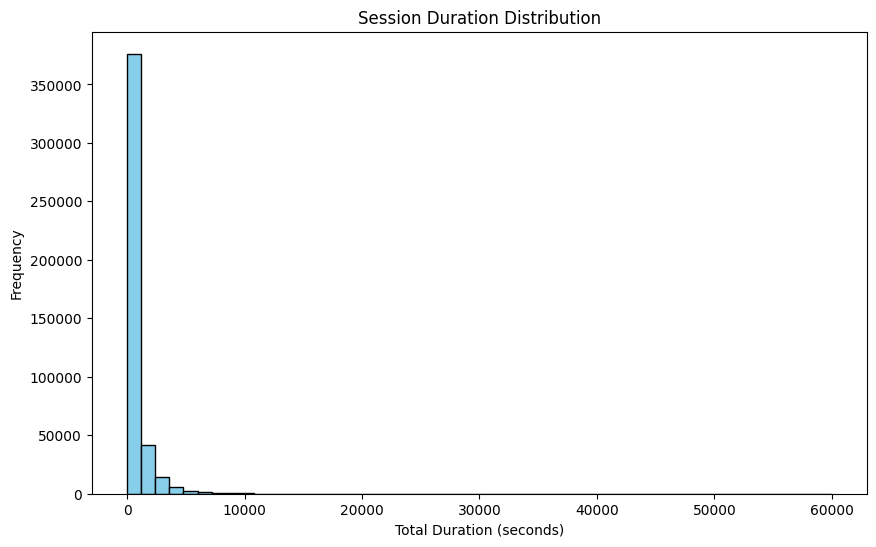

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


session = pd.read_csv('data/session.csv')
plt.figure(figsize=(10, 6))
plt.hist(session['total_duration'], bins=50, color='skyblue', edgecolor='black')
plt.title('Session Duration Distribution')
plt.xlabel('Total Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


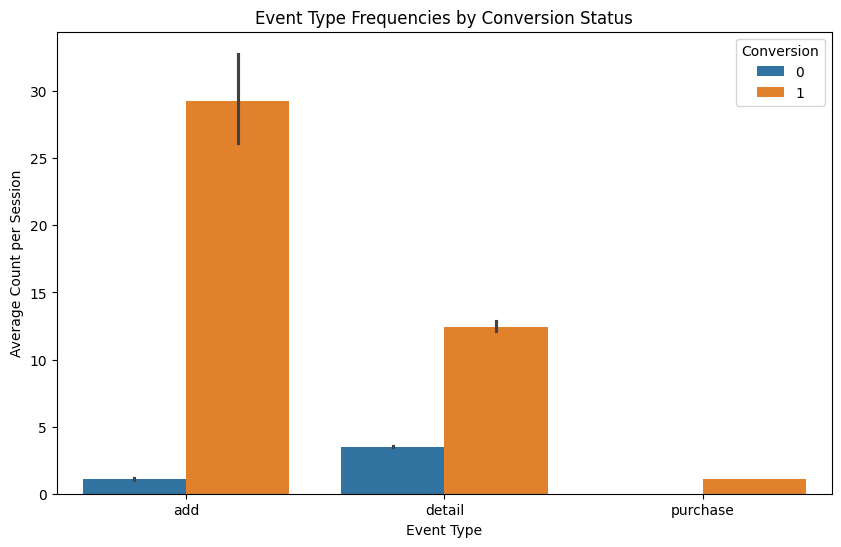

In [16]:
import seaborn as sns

action_counts = session[['add', 'detail', 'purchase', 'conversion']]
melted_counts = action_counts.melt(id_vars='conversion', var_name='event_type', value_name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_counts, x='event_type', y='count', hue='conversion')
plt.title('Event Type Frequencies by Conversion Status')
plt.xlabel('Event Type')
plt.ylabel('Average Count per Session')
plt.legend(title='Conversion')
plt.show()


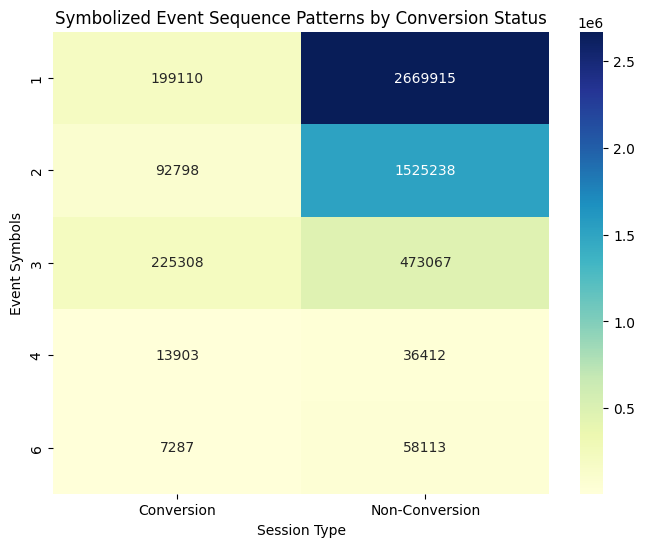

In [17]:
from collections import Counter
import numpy as np


symbol_counts_conv = Counter([symbol for sequence in session[session['conversion'] == 1]['event_sequence'] for symbol in eval(sequence)])
symbol_counts_nonconv = Counter([symbol for sequence in session[session['conversion'] == 0]['event_sequence'] for symbol in eval(sequence)])

symbols = ['1', '2', '3', '4',  '6']
conversion_counts = [symbol_counts_conv.get(int(s), 0) for s in symbols]
non_conversion_counts = [symbol_counts_nonconv.get(int(s), 0) for s in symbols]
counts_df = pd.DataFrame({'Conversion': conversion_counts, 'Non-Conversion': non_conversion_counts}, index=symbols)

plt.figure(figsize=(8, 6))
sns.heatmap(counts_df, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Symbolized Event Sequence Patterns by Conversion Status')
plt.xlabel('Session Type')
plt.ylabel('Event Symbols')
plt.show()


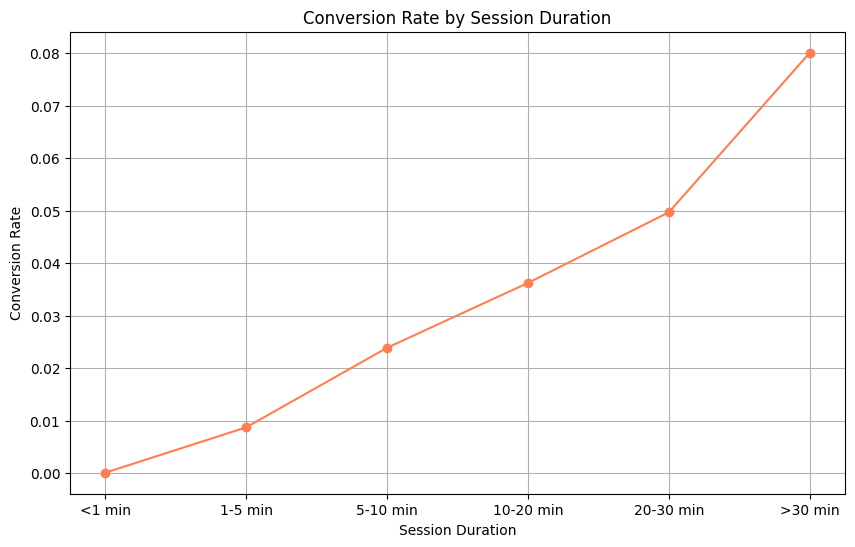

In [18]:
session['duration_bin'] = pd.cut(session['total_duration'], bins=[0, 60, 300, 600, 1200, 1800, 3600], labels=['<1 min', '1-5 min', '5-10 min', '10-20 min', '20-30 min', '>30 min'])

conversion_rate = session.groupby('duration_bin')['conversion'].mean()
plt.figure(figsize=(10, 6))
conversion_rate.plot(kind='line', marker='o', color='coral')
plt.title('Conversion Rate by Session Duration')
plt.xlabel('Session Duration')
plt.ylabel('Conversion Rate')
plt.grid(True)
plt.show()


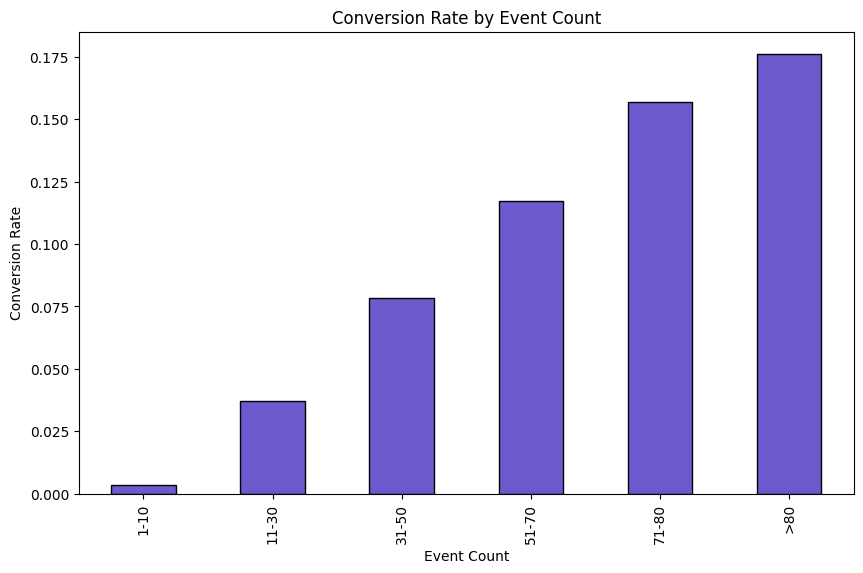

In [19]:
session['event_count_bin'] = pd.cut(session['event_count'], bins=[0, 10, 30, 50, 70, 80, 100], labels=['1-10', '11-30', '31-50', '51-70', '71-80', '>80'])
conversion_rate_event_count = session.groupby('event_count_bin')['conversion'].mean()
plt.figure(figsize=(10, 6))
conversion_rate_event_count.plot(kind='bar', color='slateblue', edgecolor='black')
plt.title('Conversion Rate by Event Count')
plt.xlabel('Event Count')
plt.ylabel('Conversion Rate')
plt.show()


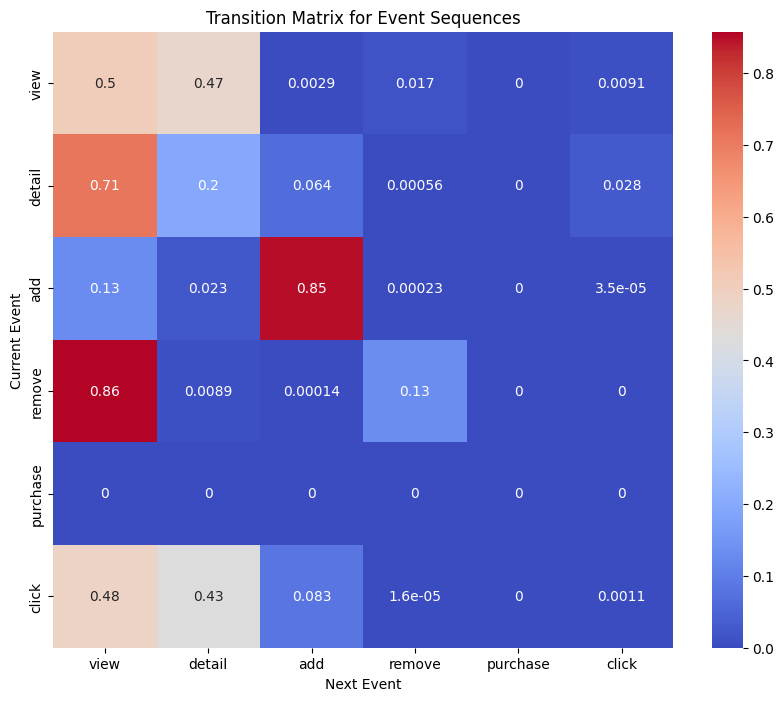

In [20]:
import seaborn as sns
from sklearn.preprocessing import normalize

symbol_sequence = session['event_sequence'].apply(eval)  
transition_counts = pd.DataFrame(0, index=symbol_map.values(), columns=symbol_map.values())
for seq in symbol_sequence:
    
    for i in range(len(seq) - 1):
        transition_counts.loc[seq[i], seq[i + 1]] += 1
transition_matrix = normalize(transition_counts, norm='l1', axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, cmap="coolwarm", xticklabels=symbol_map.keys(), yticklabels=symbol_map.keys())
plt.title('Transition Matrix for Event Sequences')
plt.xlabel('Next Event')
plt.ylabel('Current Event')
plt.show()


In [21]:
session.to_csv('data/session.csv')

In [22]:
import pickle
vis_results = {
    'action_counts': action_counts,
    'melted_counts':melted_counts,
    'conversion_counts':conversion_counts,
    'non_conversion_counts':non_conversion_counts,
    'conversion_rate':conversion_rate,
    'conversion_rate_event_count':conversion_rate_event_count,
    'transition_matrix':transition_matrix
}

with open('vis_results.pkl', 'wb') as f:
    pickle.dump(vis_results, f)

In [23]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
import ast
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

def onegrams(seq):
    o=[]
    for s in seq:
        o.append(str(s))
    o=[s for s in o if '5' not in s]
    freq_ngrams = Counter(o)
    nfreq_onegrams = {s: count / len(o) for s, count in freq_ngrams.items()}
    return nfreq_onegrams

def twograms(seq):
    t=[]
    for i in range(len(seq) - 1):
        t.append(''.join(map(str,seq[i:i+2])))
    t=[s for s in t if '5' not in s]
    freq_ngrams = Counter(t)
    nfreq_twograms = {s: count / len(t) for s, count in freq_ngrams.items() if count>0}
    return nfreq_twograms

def create_hvg(seq):
    n = len(seq)
    hvg = nx.Graph()
    for i in range(n):
        for j in range(i+1, n):
            if all(seq[k] < min(seq[i], seq[j]) for k in range(i+1, j)):
                hvg.add_edge(i, j)
    return hvg

def hvg_motifs(hvg):
    motifs = []
    nodes = list(hvg.nodes)
    for i in range(len(nodes) - 3):
        subgraph = hvg.subgraph(nodes[i:i+4])
        motif = nx.to_dict_of_lists(subgraph)
        motifs.append(tuple(sorted((frozenset(motif[k]) for k in motif))))
    return motifs

def entropy(motifs):
    counts = Counter(motifs)
    total = sum(counts.values())
    prob = [count / total for count in counts.values()]
    e = -sum(p * np.log2(p) for p in prob)
    return e

session=pd.read_csv('data/session.csv')
sequences = session['event_sequence'].apply(ast.literal_eval)
def trim_trajectory(sequences):
    if 5 in sequences:
        return sequences[:sequences.index(5)]
    else:
        return sequences
sequences = sequences.apply(trim_trajectory)
session['event_sequence']=sequences
classes = session['conversion']
all_motifs=[]
features = []
for seq in sequences:
    hvg = create_hvg(seq)
    motifs = hvg_motifs(hvg)
    all_motifs.extend(motifs)
    e = entropy(motifs)
    nfreq_onegrams=onegrams(seq)
    nfreq_twograms=twograms(seq)
    all_possible_1grams=['1','2','3','4','6']
    all_possible_2grams=['11','12','13','14','16','21','22','23','24','26','31','32','33','34','36','41','42','43','44','46','61','62','63','64','66']
    onegramss = [nfreq_onegrams.get(gram, 0) for gram in all_possible_1grams]
    twogramss = [nfreq_twograms.get(kgram, 0) for kgram in all_possible_2grams]
    features.append((onegramss,twogramss,motifs, e))

motif_counts = Counter(all_motifs)
mostcommon_motifs = [motif for motif, c in motif_counts.most_common(6)]


In [24]:
data1=pd.DataFrame()
data1['motifs']=mostcommon_motifs
data1.to_csv('data/motiflist.csv')

In [25]:
X = []
for oneg,twog,motifs, e in features:
    counts = Counter(motifs)
    motif_cnt = [counts.get(motif, 0)  for motif in mostcommon_motifs]
    X.append(oneg+twog+motif_cnt + [e])

X = np.array(X)
y = np.array(classes)
def balance_dataset(X, Y):
    classc = np.where(Y == 1)[0] 
    classnc = np.where(Y == 0)[0]  
    np.random.shuffle(classnc)
    classnc = classnc[:len(classc)]
    balanced = np.concatenate([classc, classnc])
    np.random.shuffle(balanced)
    
    return X[balanced], Y[balanced]

f1_lr = []
auc_lr = []
acc_lr = []
prec_lr = []
rec_lr = []

for i in range(7):
    balanced_features, balanced_labels = balance_dataset(X, y)
    label_encoder = LabelEncoder()
    balanced_labels = label_encoder.fit_transform(balanced_labels)
    X_train, X_test, y_train, y_test = train_test_split(balanced_features, balanced_labels, test_size=0.2, random_state=i)
    
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    with open(f'models/lr_model_{i}.pkl', 'wb') as f:
        pickle.dump(lr, f)
    y_pred_lr = lr.predict(X_test)
    y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]
    
    f1_lr.append(f1_score(y_test, y_pred_lr, pos_label=1))
    auc_lr.append(roc_auc_score(y_test, y_pred_proba_lr))
    acc_lr.append(accuracy_score(y_test, y_pred_lr))
    prec_lr.append(precision_score(y_test, y_pred_lr, pos_label=1))
    rec_lr.append(recall_score(y_test, y_pred_lr, pos_label=1))

mean_f1_lr = np.mean(f1_lr)
std_f1_lr = np.std(f1_lr)
mean_auc_lr = np.mean(auc_lr)
std_auc_lr = np.std(auc_lr)
mean_acc_lr = np.mean(acc_lr)
std_acc_lr = np.std(acc_lr)
mean_prec_lr = np.mean(prec_lr)
std_prec_lr = np.std(prec_lr)
mean_rec_lr = np.mean(rec_lr)
std_rec_lr = np.std(rec_lr)

print(f'LR - F1 Score: {mean_f1_lr:.4f} ± {std_f1_lr:.4f}')
print(f'LR - AUC: {mean_auc_lr:.4f} ± {std_auc_lr:.4f}')
print(f'LR - Accuracy: {mean_acc_lr:.4f} ± {std_acc_lr:.4f}')
print(f'LR - Precision: {mean_prec_lr:.4f} ± {std_prec_lr:.4f}')
print(f'LR - Recall: {mean_rec_lr:.4f} ± {std_rec_lr:.4f}')


LR - F1 Score: 0.8833 ± 0.0041
LR - AUC: 0.9452 ± 0.0031
LR - Accuracy: 0.8821 ± 0.0042
LR - Precision: 0.8734 ± 0.0065
LR - Recall: 0.8934 ± 0.0041


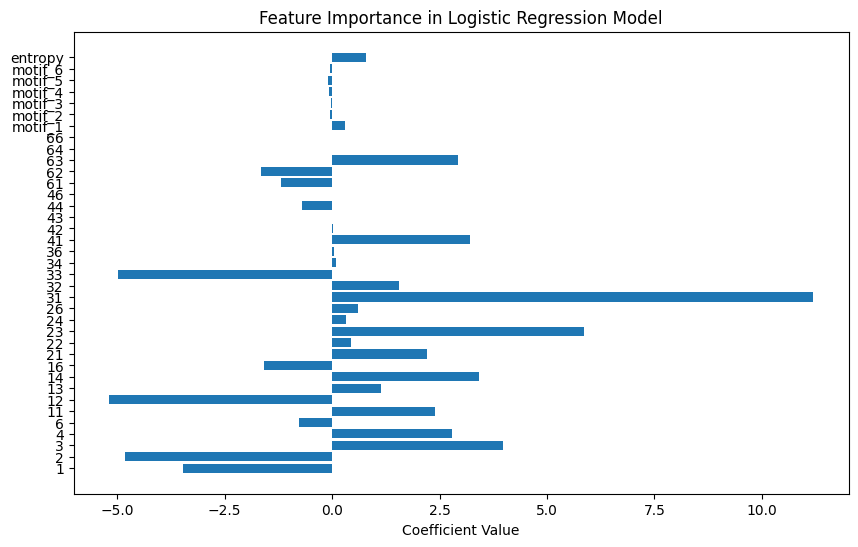

In [26]:
import matplotlib.pyplot as plt
import numpy as np

coefficients = lr.coef_.flatten()
feature_names = all_possible_1grams + \
                all_possible_2grams + \
                ['motif_' + str(i+1) for i in range(len(mostcommon_motifs))] + ['entropy']
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Logistic Regression Model")
plt.show()


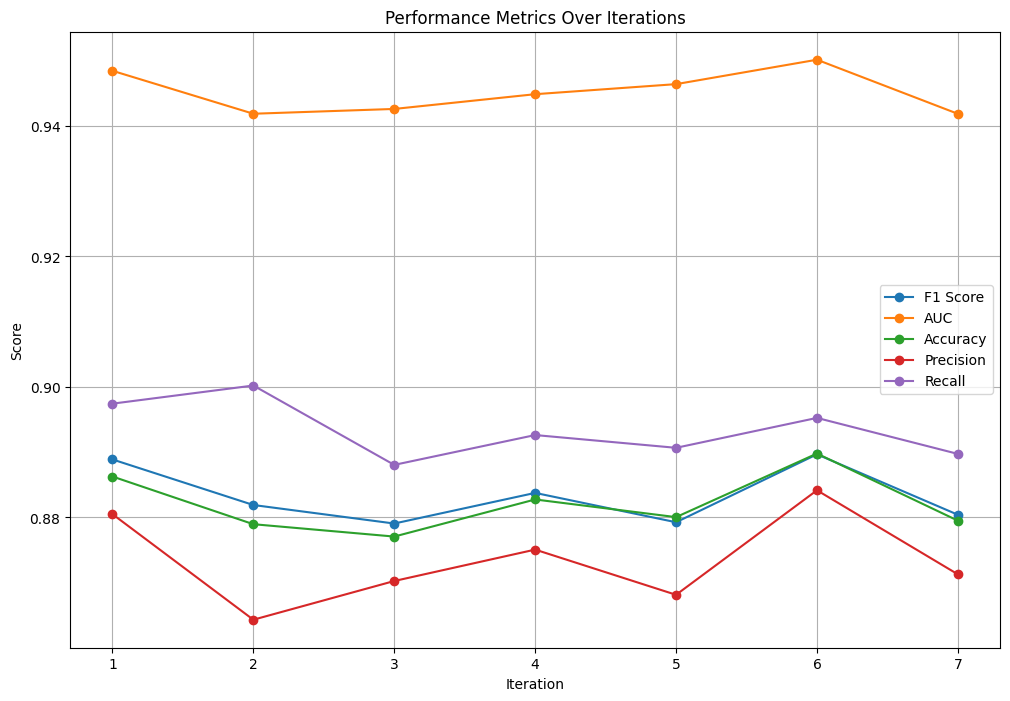

In [27]:

iterations = list(range(1, 8))

plt.figure(figsize=(12, 8))
plt.plot(iterations, f1_lr, label="F1 Score", marker='o')
plt.plot(iterations, auc_lr, label="AUC", marker='o')
plt.plot(iterations, acc_lr, label="Accuracy", marker='o')
plt.plot(iterations, prec_lr, label="Precision", marker='o')
plt.plot(iterations, rec_lr, label="Recall", marker='o')
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Performance Metrics Over Iterations")
plt.legend()
plt.grid()
plt.show()


In [28]:
results = {
    'mean_f1_lr': mean_f1_lr,
    'std_f1_lr': std_f1_lr,
    'mean_auc_lr': mean_auc_lr,
    'std_auc_lr': std_auc_lr,
    'mean_acc_lr': mean_acc_lr,
    'std_acc_lr': std_acc_lr,
    'mean_prec_lr': mean_prec_lr,
    'std_prec_lr': std_prec_lr,
    'mean_rec_lr': mean_rec_lr,
    'std_rec_lr': std_rec_lr,
    'coefficients': coefficients,
    'feature_names': feature_names,
    'f1_lr': f1_lr,
    'auc_lr': auc_lr,
    'acc_lr': acc_lr,
    'prec_lr': prec_lr,
    'rec_lr': rec_lr,
}

with open('lr_model_results.pkl', 'wb') as f:
    pickle.dump(results, f)


In [29]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics = {
    'f1': {'rf': [], 'xgb': []},
    'auc': { 'rf': [], 'xgb': []},
    'accuracy': {'rf': [], 'xgb': []},
    'precision': {'rf': [], 'xgb': []},
    'recall': { 'rf': [], 'xgb': []}
}

for i in range(10):
    balanced_features, balanced_labels = balance_dataset(X, y)
    X_train, X_test, y_train, y_test = train_test_split(balanced_features, balanced_labels, test_size=0.2, random_state=i)
    rf = RandomForestClassifier(n_estimators=100, random_state=i)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
    
    metrics['f1']['rf'].append(f1_score(y_test, y_pred_rf))
    metrics['auc']['rf'].append(roc_auc_score(y_test, y_pred_proba_rf))
    metrics['accuracy']['rf'].append(accuracy_score(y_test, y_pred_rf))
    metrics['precision']['rf'].append(precision_score(y_test, y_pred_rf))
    metrics['recall']['rf'].append(recall_score(y_test, y_pred_rf))

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=i)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
    
    metrics['f1']['xgb'].append(f1_score(y_test, y_pred_xgb))
    metrics['auc']['xgb'].append(roc_auc_score(y_test, y_pred_proba_xgb))
    metrics['accuracy']['xgb'].append(accuracy_score(y_test, y_pred_xgb))
    metrics['precision']['xgb'].append(precision_score(y_test, y_pred_xgb))
    metrics['recall']['xgb'].append(recall_score(y_test, y_pred_xgb))




C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [08:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [08:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [08:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg,

In [30]:
for model in metrics['f1']:
    print(f"\n{model.upper()} Model Metrics:")
    for metric_name in metrics:
        mean_metric = np.mean(metrics[metric_name][model])
        std_metric = np.std(metrics[metric_name][model])
        print(f"{metric_name.capitalize()} - Mean: {mean_metric:.4f} ± {std_metric:.4f}")


RF Model Metrics:
F1 - Mean: 0.8996 ± 0.0042
Auc - Mean: 0.9564 ± 0.0023
Accuracy - Mean: 0.8984 ± 0.0040
Precision - Mean: 0.8909 ± 0.0081
Recall - Mean: 0.9086 ± 0.0121

XGB Model Metrics:
F1 - Mean: 0.9020 ± 0.0049
Auc - Mean: 0.9601 ± 0.0026
Accuracy - Mean: 0.9009 ± 0.0046
Precision - Mean: 0.8935 ± 0.0096
Recall - Mean: 0.9109 ± 0.0152


Evaluating early prediction with T = 5
Earliness for T = 5: 86.05%
T = 5, F1 Score: 0.7368, AUC: 0.7088, Earliness: 86.05%

Evaluating early prediction with T = 6
Earliness for T = 6: 83.26%
T = 6, F1 Score: 0.7213, AUC: 0.7052, Earliness: 83.26%

Evaluating early prediction with T = 7
Earliness for T = 7: 80.47%
T = 7, F1 Score: 0.7683, AUC: 0.7452, Earliness: 80.47%

Evaluating early prediction with T = 8
Earliness for T = 8: 77.68%
T = 8, F1 Score: 0.7646, AUC: 0.7596, Earliness: 77.68%

Evaluating early prediction with T = 9
Earliness for T = 9: 74.89%
T = 9, F1 Score: 0.7699, AUC: 0.7728, Earliness: 74.89%

Evaluating early prediction with T = 10
Earliness for T = 10: 72.10%
T = 10, F1 Score: 0.7793, AUC: 0.7889, Earliness: 72.10%

Evaluating early prediction with T = 11
Earliness for T = 11: 69.31%
T = 11, F1 Score: 0.7913, AUC: 0.8235, Earliness: 69.31%

Evaluating early prediction with T = 12
Earliness for T = 12: 66.52%
T = 12, F1 Score: 0.7896, AUC: 0.8172, Earliness: 66.52%


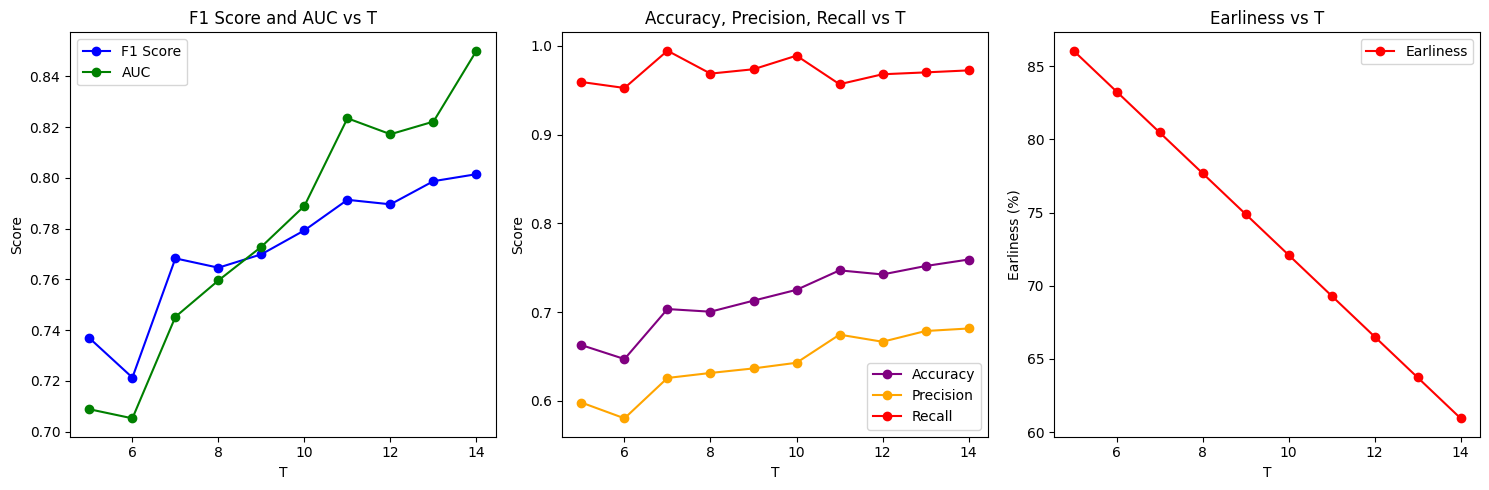

In [33]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
session = pd.read_csv('data/session.csv')
T_values = range(5, 15)
f1_lr_t = []
auc_lr_t = []
acc_lr_t = []
prec_lr_t = []
rec_lr_t = []
earliness_values = []

def calculate_earliness(T, lengths):
    return 100 * (1 - (T / np.mean(lengths)))

for T in T_values:
    print(f"Evaluating early prediction with T = {T}")
    session['trimmed_event_sequence'] = session['event_sequence'].apply(lambda seq: seq[:T])
    lengths = session['event_sequence'].apply(len)
    earliness = calculate_earliness(T, lengths)
    earliness_values.append(earliness)
    print(f"Earliness for T = {T}: {earliness:.2f}%")

    features = []
    all_motifs = []
    for seq in session['trimmed_event_sequence']:
        hvg = create_hvg(seq)
        motifs = hvg_motifs(hvg)
        all_motifs.extend(motifs)
        e = entropy(motifs)
        nfreq_onegrams = onegrams(seq)
        nfreq_twograms = twograms(seq)
        all_possible_1grams = ['1', '2', '3', '4', '6']
        all_possible_2grams = [
            '11', '12', '13', '14', '16', '21', '22', '23', '24', '26',
            '31', '32', '33', '34', '36', '41', '42', '43', '44', '46',
            '61', '62', '63', '64', '66'
        ]
        
        onegram_features = [nfreq_onegrams.get(gram, 0) for gram in all_possible_1grams]
        twogram_features = [nfreq_twograms.get(kgram, 0) for kgram in all_possible_2grams]
        features.append(onegram_features + twogram_features + [e])
    motif_counts = Counter(all_motifs)
    mostcommon_motifs = [motif for motif, count in motif_counts.most_common(6)]
    
    X = []
    for feature_set in features:
        onegram_twogram, e = feature_set[:-1], feature_set[-1]
        counts = Counter(feature_set[:-1])
        motif_counts = [counts.get(motif, 0) for motif in mostcommon_motifs]
        X.append(onegram_twogram + motif_counts + [e])

    X = np.array(X)
    y = session['conversion'].values  
    balanced_features, balanced_labels = balance_dataset(X, y)
    label_encoder = LabelEncoder()
    balanced_labels = label_encoder.fit_transform(balanced_labels)
    
    X_train, X_test, y_train, y_test = train_test_split(balanced_features, balanced_labels, test_size=0.2, random_state=T)
    
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    
    with open(f'models/lr_model_T_{T}.pkl', 'wb') as f:
        pickle.dump(lr, f)
    y_pred = lr.predict(X_test)
    y_pred_proba = lr.predict_proba(X_test)[:, 1]
    
    f1_lr_t.append(f1_score(y_test, y_pred, pos_label=1))
    auc_lr_t.append(roc_auc_score(y_test, y_pred_proba))
    acc_lr_t.append(accuracy_score(y_test, y_pred))
    prec_lr_t.append(precision_score(y_test, y_pred, pos_label=1))
    rec_lr_t.append(recall_score(y_test, y_pred, pos_label=1))

    print(f"T = {T}, F1 Score: {f1_lr_t[-1]:.4f}, AUC: {auc_lr_t[-1]:.4f}, Earliness: {earliness:.2f}%\n")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(T_values, f1_lr_t, marker='o', color='b', label='F1 Score')
plt.plot(T_values, auc_lr_t, marker='o', color='g', label='AUC')
plt.title("F1 Score and AUC vs T")
plt.xlabel("T")
plt.ylabel("Score")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(T_values, acc_lr_t, marker='o', color='purple', label='Accuracy')
plt.plot(T_values, prec_lr_t, marker='o', color='orange', label='Precision')
plt.plot(T_values, rec_lr_t, marker='o', color='red', label='Recall')
plt.title("Accuracy, Precision, Recall vs T")
plt.xlabel("T")
plt.ylabel("Score")
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(T_values, earliness_values, marker='o', color='r', label='Earliness')
plt.title("Earliness vs T")
plt.xlabel("T")
plt.ylabel("Earliness (%)")
plt.legend()

plt.tight_layout()
plt.show()


In [59]:
results = {
    'mean_f1_lr': mean_f1_lr,
    'std_f1_lr': std_f1_lr,
    'mean_auc_lr': mean_auc_lr,
    'std_auc_lr': std_auc_lr,
    'mean_acc_lr': mean_acc_lr,
    'std_acc_lr': std_acc_lr,
    'mean_prec_lr': mean_prec_lr,
    'std_prec_lr': std_prec_lr,
    'mean_rec_lr': mean_rec_lr,
    'std_rec_lr': std_rec_lr,
    'coefficients': coefficients,
    'feature_names': feature_names,
    'f1_lr': f1_lr,
    'auc_lr': auc_lr,
    'acc_lr': acc_lr,
    'prec_lr': prec_lr,
    'rec_lr': rec_lr,
    'metrics': metrics,
    'f1_lr_t':f1_lr_t,
    'auc_lr_t':auc_lr_t,
    'acc_lr_t':acc_lr_t ,
    'prec_lr_t':prec_lr_t ,
    'rec_lr_t':rec_lr_t ,
    'earliness_values':earliness_values, 
}

with open('lr_model_results.pkl', 'wb') as f:
    pickle.dump(results, f)


C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [08:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


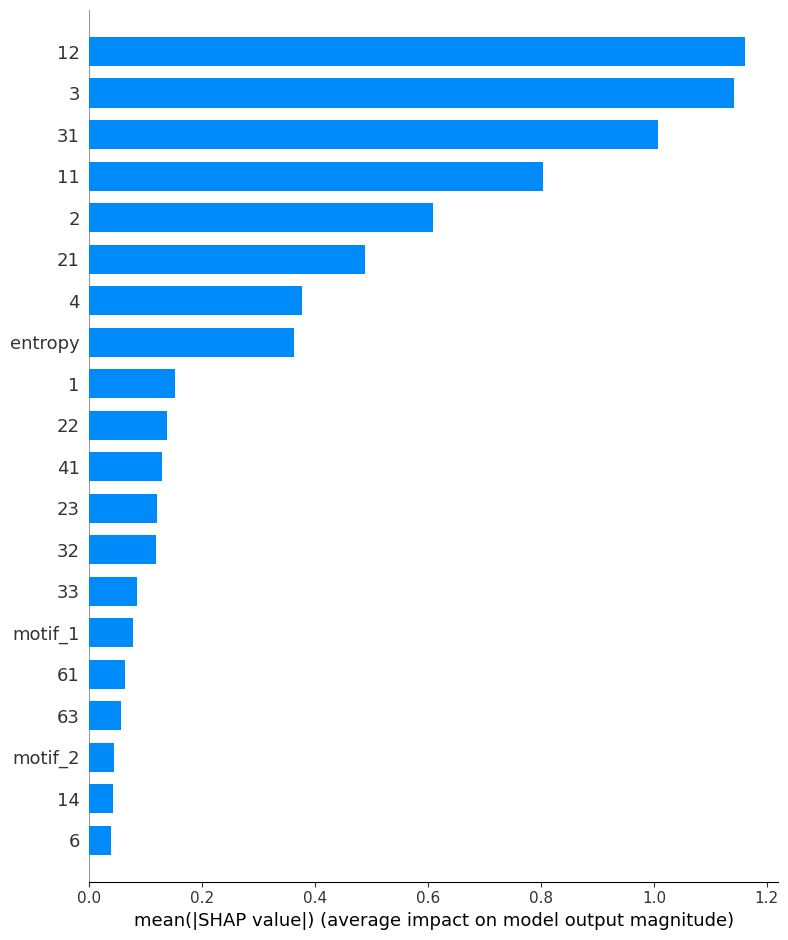

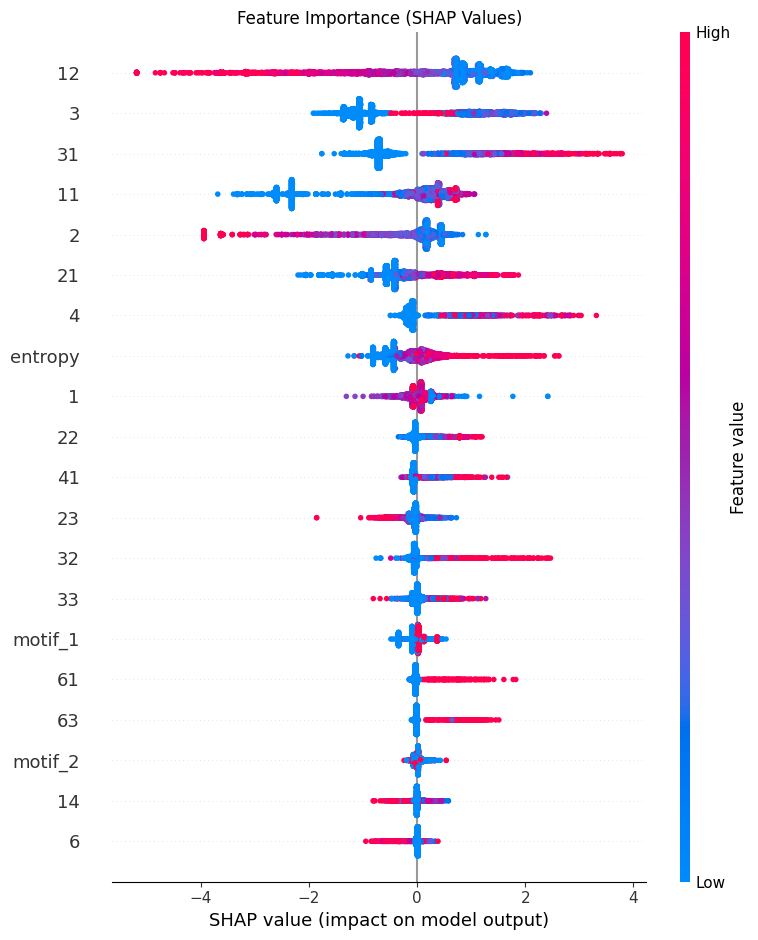

In [32]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


X_train, X_test, y_train, y_test = train_test_split(balanced_features, balanced_labels, test_size=0.2, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names)
plt.title("Feature Importance (SHAP Values)")
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
plt.show()

index = 0 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[index], X_test[index], feature_names=feature_names)
plt.show()


In [50]:
from sklearn.model_selection import train_test_split

def split(session):

    conversion_sessions = session[session['conversion'] == 1]
    non_conversion_sessions = session[session['conversion'] == 0]
    non_conversion_sample = non_conversion_sessions.sample(n=len(conversion_sessions), random_state=42)
    balanced_data = pd.concat([conversion_sessions, non_conversion_sample])
    train_data, test_data = train_test_split(balanced_data, test_size=0.2, random_state=42)
    return train_data,test_data


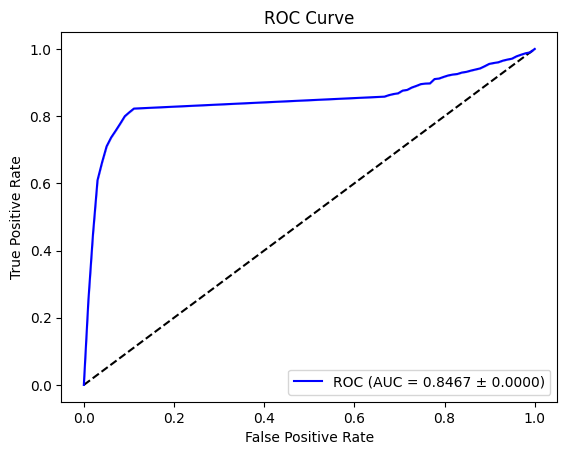

Markov Chain Classifier Results (k=5):
F1 Score: 0.8526 ± 0.0000
AUC: 0.8467 ± 0.0000
Accuracy: 0.8568 ± 0.0000
Precision: 0.8859 ± 0.0000
Recall: 0.8217 ± 0.0000


In [56]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,roc_curve
acc_m=[]
f1_m=[]
prec_m=[]
rec_m=[]
auc_m=[]
mean_fpr = np.linspace(0, 1, 100)
tprs = []
for z in range(10):
    train_data, test_data=split(session)
    conversion_train = train_data[train_data['conversion'] == 1]['event_sequence'].apply(eval).tolist()
    non_conversion_train = train_data[train_data['conversion'] == 0]['event_sequence'].apply(eval).tolist()
    conversion_test = test_data[test_data['conversion'] == 1]['event_sequence'].apply(eval).tolist()
    non_conversion_test = test_data[test_data['conversion'] == 0]['event_sequence'].apply(eval).tolist()
    k = 5 
    def generate_kgrams(sequence, k):
        return [tuple(sequence[i:i+k]) for i in range(len(sequence) - k + 1)]

    def build_transition_matrix(sequences, k):
        transitions = defaultdict(Counter)
        for seq in sequences:
            kgrams = generate_kgrams(seq, k)
            for gram in kgrams:
                prefix, next_state = gram[:-1], gram[-1]
                transitions[prefix][next_state] += 1

        transition_matrix = {prefix: {next_state: count / sum(suffix_counts.values())
                                    for next_state, count in suffix_counts.items()}
                            for prefix, suffix_counts in transitions.items()}
        return transition_matrix


    transition_matrix_C = build_transition_matrix(conversion_train, k)
    transition_matrix_NC = build_transition_matrix(non_conversion_train, k)
    prior_C = len(conversion_train) / (len(conversion_train) + len(non_conversion_train))
    prior_NC = 1 - prior_C


    def calculate_sequence_likelihood(sequence, transition_matrix, k):
        kgrams = generate_kgrams(sequence, k)
        likelihood = 1.0
        for gram in kgrams:
            prefix, next_state = gram[:-1], gram[-1]
            likelihood *= transition_matrix.get(prefix, {}).get(next_state, 1e-10)  
        return likelihood

    def classify_sequence(sequence, prior_C, prior_NC, k):
        likelihood_C = calculate_sequence_likelihood(sequence, transition_matrix_C, k)
        likelihood_NC = calculate_sequence_likelihood(sequence, transition_matrix_NC, k)
        posterior_C = prior_C * likelihood_C
        posterior_NC = prior_NC * likelihood_NC
        
        return 1 if posterior_C > posterior_NC else 0

    y_true = [1] * len(conversion_test) + [0] * len(non_conversion_test)
    y_pred = []
    y_pred_proba=[]
    for sequence in conversion_test + non_conversion_test:
        likelihood_C = calculate_sequence_likelihood(sequence, transition_matrix_C, k)
        likelihood_NC = calculate_sequence_likelihood(sequence, transition_matrix_NC, k)
        posterior_C = prior_C * likelihood_C
        posterior_NC = prior_NC * likelihood_NC
        y_pred.append(classify_sequence(sequence, prior_C, prior_NC, k))
        y_pred_proba.append(posterior_C / (posterior_C + posterior_NC))

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    f1_m.append(f1)
    auc_m.append(auc)
    acc_m.append(accuracy)
    prec_m.append(precision)
    rec_m.append(recall)

mean_f1_m = np.mean(f1_m)
std_f1_m = np.std(f1_m)
mean_auc_m = np.mean(auc_m)
std_auc_m = np.std(auc_m)
mean_acc_m = np.mean(acc_m)
std_acc_m = np.std(acc_m)
mean_prec_m = np.mean(prec_m)
std_prec_m = np.std(prec_m)
mean_rec_m = np.mean(rec_m)
std_rec_m = np.std(rec_m)
plt.plot([0, 1], [0, 1], 'k--')
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_m)
std_auc = np.std(auc_m)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})')
plt.fill_between(mean_fpr, np.maximum(mean_tpr - np.std(tprs, axis=0), 0), np.minimum(mean_tpr + np.std(tprs, axis=0), 1), color='blue', alpha=0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
print(f"Markov Chain Classifier Results (k={k}):")
print(f'F1 Score: {mean_f1_m:.4f} ± {std_f1_m:.4f}')
print(f'AUC: {mean_auc_m:.4f} ± {std_auc_m:.4f}')
print(f'Accuracy: {mean_acc_m:.4f} ± {std_acc_m:.4f}')
print(f'Precision: {mean_prec_m:.4f} ± {std_prec_m:.4f}')
print(f'Recall: {mean_rec_m:.4f} ± {std_rec_m:.4f}')





In [61]:
results1 = {
    'mean_f1_m': mean_f1_m,
    'std_f1_m': std_f1_m,
    'mean_auc_m': mean_auc_m,
    'std_auc_m': std_auc_m,
    'mean_acc_m': mean_acc_m,
    'std_acc_m': std_acc_m,
    'mean_prec_m': mean_prec_m,
    'std_prec_m': std_prec_m,
    'mean_rec_m': mean_rec_m,
    'std_rec_m': std_rec_m,
    'mean_fpr' : mean_fpr,
    'tprs' :tprs, 
    'auc_m': auc_m, 
    
}

with open('mc_model_results.pkl', 'wb') as f:
    pickle.dump(results1, f)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import ast
train_data, test_data=split(session)

max_seq_len = 100  
embedding_dim = 32
lstm_units = 64
batch_size = 32
epochs = 20
learning_rate = 0.001
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen))
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded_sequences[i] = np.array(seq[:maxlen])
        else:
            padded_sequences[i, :len(seq)] = np.array(seq)
    return padded_sequences
X_train = pad_sequences(train_data['event_sequence'], maxlen=max_seq_len)
y_train = train_data['conversion'].values
X_test = pad_sequences(test_data['event_sequence'], maxlen=max_seq_len)
y_test = test_data['conversion'].values

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_seq_len,)))  
model.add(Embedding(input_dim=6 + 1, output_dim=embedding_dim, input_length=max_seq_len))
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=lstm_units))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()



Epoch 1/20


C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'embedding' (of type Embedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


370/370 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.6936 - loss: 0.5549 - val_accuracy: 0.7926 - val_loss: 0.4691
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.5722 - loss: 0.6504 - val_accuracy: 0.5421 - val_loss: 0.6858
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.6863 - loss: 0.5664 - val_accuracy: 0.8758 - val_loss: 0.3164
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.8855 - loss: 0.3251 - val_accuracy: 0.8853 - val_loss: 0.3039
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8864 - loss: 0.3185 - val_accuracy: 0.8866 - val_loss: 0.3347
Epoch 6/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.8820 - loss: 0.3170 - val_accuracy: 0.8880 - val_loss: 0.2968
Epoch 7/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.8885 - loss: 0.2998 - val_accuracy: 0.8870 - val_loss: 0.2936
Epoch 8/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.8840 - loss: 0.3024 - val_accurac

In [ ]:

model.save("models/lstm_model_f.keras")

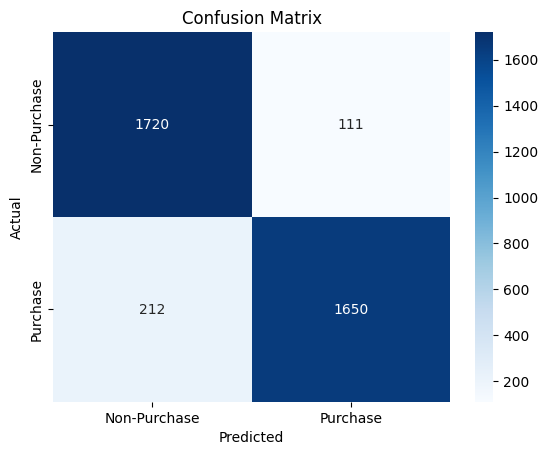

In [36]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Purchase", "Purchase"], yticklabels=["Non-Purchase", "Purchase"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [37]:
print("LSTM Model - Accuracy:", accuracy_score(y_test, y_pred))
print("LSTM Model - AUC:", roc_auc_score(y_test, y_pred))
print("Precision (Purchase):", precision_score(y_test, y_pred, pos_label=1))
print("Recall (Purchase):", recall_score(y_test, y_pred, pos_label=1))
print("F1 Score (Purchase):", f1_score(y_test, y_pred, pos_label=1))
print("Precision (Non-Purchase):", precision_score(y_test, y_pred, pos_label=0))
print("Recall (Non-Purchase):", recall_score(y_test, y_pred, pos_label=0))
print("F1 Score (Non-Purchase):", f1_score(y_test, y_pred, pos_label=0))
accuracy_lstm=accuracy_score(y_test,y_pred)
auc_lstm=roc_auc_score(y_test, y_pred)
precision_purchase= precision_score(y_test, y_pred, pos_label=1)
recall_purchase=recall_score(y_test, y_pred, pos_label=1)
f1_purchase=f1_score(y_test, y_pred, pos_label=1)
precision_non_purchase=precision_score(y_test, y_pred, pos_label=0)
recall_non_purchase=recall_score(y_test, y_pred, pos_label=0)
f1_non_purchase= f1_score(y_test, y_pred, pos_label=0)

LSTM Model - Accuracy: 0.9125372326022204
LSTM Model - AUC: 0.9127606603307049
Precision (Purchase): 0.9369676320272572
Recall (Purchase): 0.8861439312567132
F1 Score (Purchase): 0.9108473640629313
Precision (Non-Purchase): 0.8902691511387164
Recall (Non-Purchase): 0.9393773894046968
F1 Score (Non-Purchase): 0.914164230667021


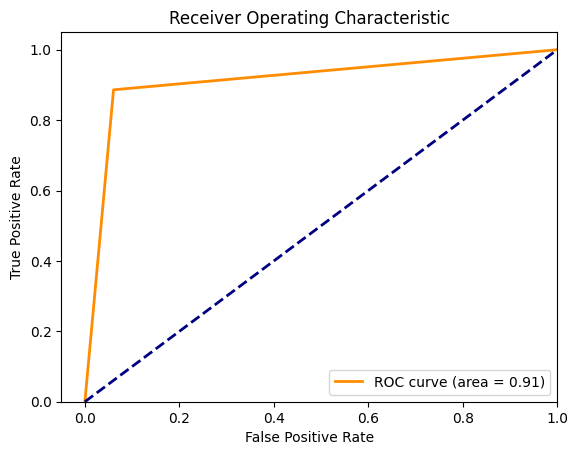

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



Training with window size: 5
Epoch 1/5


C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5279 - loss: 0.6726 - val_accuracy: 0.8170 - val_loss: 0.4861
Epoch 2/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8579 - loss: 0.4510 - val_accuracy: 0.8844 - val_loss: 0.3727
Epoch 3/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8860 - loss: 0.3571 - val_accuracy: 0.8949 - val_loss: 0.3192
Epoch 4/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8972 - loss: 0.3169 - val_accuracy: 0.9047 - val_loss: 0.3122
Epoch 5/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8921 - loss: 0.3047 - val_accuracy: 0.8971 - val_loss: 0.2908
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training with window size: 10
Epoch 1/5


C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


462/462 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6764 - loss: 0.5866 - val_accuracy: 0.8800 - val_loss: 0.4043
Epoch 2/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8719 - loss: 0.3744 - val_accuracy: 0.8939 - val_loss: 0.3032
Epoch 3/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9006 - loss: 0.2868 - val_accuracy: 0.9055 - val_loss: 0.2802
Epoch 4/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8966 - loss: 0.2726 - val_accuracy: 0.8966 - val_loss: 0.2844
Epoch 5/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9009 - loss: 0.2564 - val_accuracy: 0.9050 - val_loss: 0.2453
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training with window size: 20
Epoch 1/5


C:\Users\nivit\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


462/462 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7057 - loss: 0.6186 - val_accuracy: 0.8532 - val_loss: 0.3987
Epoch 2/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8698 - loss: 0.3694 - val_accuracy: 0.8960 - val_loss: 0.2862
Epoch 3/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8980 - loss: 0.2826 - val_accuracy: 0.8922 - val_loss: 0.2623
Epoch 4/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8989 - loss: 0.2540 - val_accuracy: 0.9033 - val_loss: 0.2366
Epoch 5/5
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9046 - loss: 0.2404 - val_accuracy: 0.9055 - val_loss: 0.2293
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


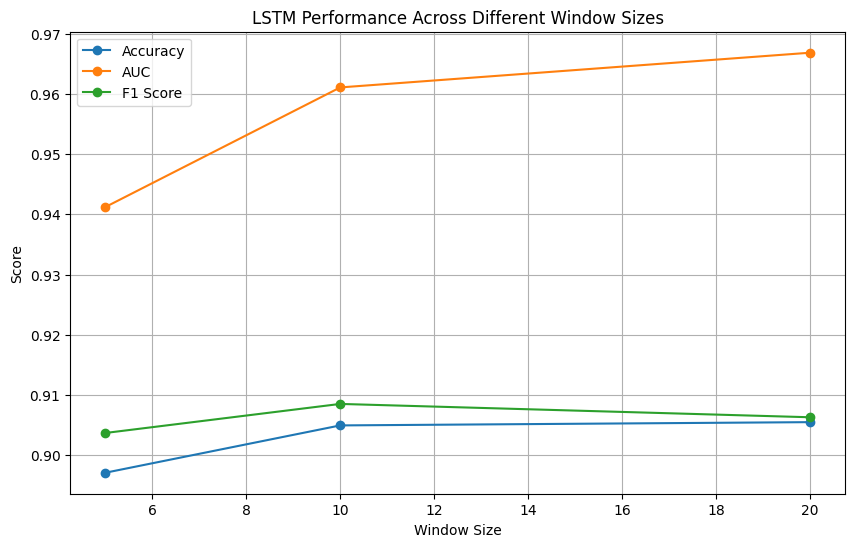

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


window_sizes = [5, 10, 20]
accuracies, auc_scores, f1_scores = [], [], []
for window_size in window_sizes:
    print(f"\nTraining with window size: {window_size}")

    X_train = pad_sequences(train_data['event_sequence'], maxlen=window_size)
    y_train = train_data['conversion'].values
    X_test = pad_sequences(test_data['event_sequence'], maxlen=window_size)
    y_test = test_data['conversion'].values


    model = Sequential([
        Masking(mask_value=0, input_shape=(window_size, 1)),
        LSTM(15, activation='relu', return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

 
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)
    y_pred_prob = model.predict(X_test).flatten()  
    y_pred = (y_pred_prob > 0.5).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred_prob))
    f1_scores.append(f1_score(y_test, y_pred))
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies, marker='o', label='Accuracy')
plt.plot(window_sizes, auc_scores, marker='o', label='AUC')
plt.plot(window_sizes, f1_scores, marker='o', label='F1 Score')
plt.xlabel('Window Size')
plt.ylabel('Score')
plt.title('LSTM Performance Across Different Window Sizes')
plt.legend()
plt.grid()
plt.show()

In [ ]:
lstm_results = {
    'accuracy': accuracy_lstm,
    'auc': auc_lstm,
    'precision_purchase': precision_purchase,
    'recall_purchase': recall_purchase,
    'f1_purchase': f1_purchase,
    'precision_non_purchase': precision_non_purchase,
    'recall_non_purchase': recall_non_purchase,
    'f1_non_purchase': f1_non_purchase,
    'window_sizes': window_sizes,
    'accuracies': accuracies,
    'auc_scores': auc_scores,
    'f1_scores': f1_scores,
    'cm': cm,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc':roc_auc
}


with open('lstm_model_results.pkl', 'wb') as f:
    pickle.dump(lstm_results, f)
    